In [1]:
# Imports necessary libraries for data processing, model building, and visualization.
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
# Mounts Google Drive to the Colab environment to access files stored on Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


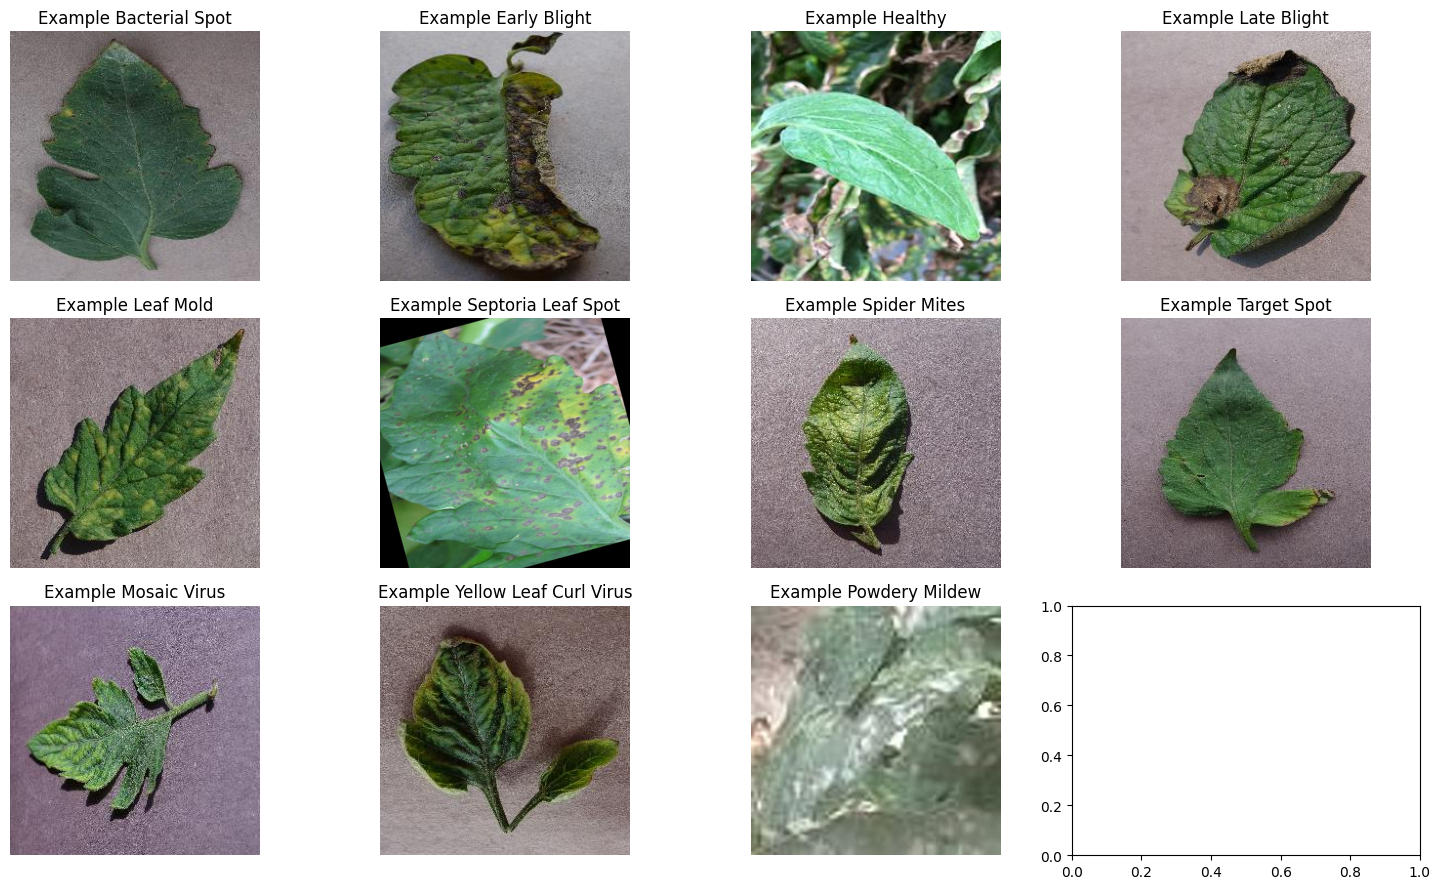

In [3]:
# Displays example images from various categories in the dataset.
BASE_DIR = "./drive/My Drive/dataset/"

directories = {
    "Bacterial Spot": os.path.join(BASE_DIR, "Bacterial_spot/"),
    "Early Blight": os.path.join(BASE_DIR, "Early_blight/"),
    "Healthy": os.path.join(BASE_DIR, "healthy/"),
    "Late Blight": os.path.join(BASE_DIR, "Late_blight/"),
    "Leaf Mold": os.path.join(BASE_DIR, "Leaf_Mold/"),
    "Septoria Leaf Spot": os.path.join(BASE_DIR, "Septoria_leaf_spot/"),
    "Spider Mites": os.path.join(BASE_DIR, "Spider_mites Two-spotted_spider_mite/"),
    "Target Spot": os.path.join(BASE_DIR, "Target_Spot/"),
    "Mosaic Virus": os.path.join(BASE_DIR, "Tomato_mosaic_virus/"),
    "Yellow Leaf Curl Virus": os.path.join(BASE_DIR, "Tomato_Yellow_Leaf_Curl_Virus/"),
    "Powdery Mildew": os.path.join(BASE_DIR, "powdery_mildew/")
}

fig, axs = plt.subplots(3, 4, figsize=(15, 9))
axs = axs.ravel()

for idx, (title, directory) in enumerate(directories.items()):
    img_path = os.path.join(directory, os.listdir(directory)[0])
    axs[idx].imshow(tf.keras.utils.load_img(img_path))
    axs[idx].set_title(f'Example {title}')
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Checks the format of an image at the given path, converts the image at the given path to JPG format and removes the original file, and processes all images in the provided directories.
from PIL import Image

def check_image_format(image_path):
  try:
    img = Image.open(image_path)
    return img.format
  except IOError:
    return None

def convert_to_jpg(image_path):
  try:
    img = Image.open(image_path)
    rgb_img = img.convert('RGB')
    rgb_img.save(image_path[:-4] + '.jpg', 'JPEG')
    os.remove(image_path)
  except IOError:
    print(f"Gagal mengonversi {image_path}")

for directory in directories.values():
  for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    if check_image_format(image_path) not in ["JPEG", "PNG", "GIF", "BMP"]:
      convert_to_jpg(image_path)

In [5]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=BASE_DIR,
    image_size=(120, 120),
    batch_size=128,
    label_mode='categorical'
)

train_size = int(0.8 * full_dataset.cardinality().numpy())
val_test_size = full_dataset.cardinality().numpy() - train_size

training_dataset = full_dataset.take(train_size)
val_test_dataset = full_dataset.skip(train_size)

validation_size = int(0.75 * val_test_size)
testing_size = val_test_size - validation_size

validation_dataset = val_test_dataset.take(validation_size)
test_dataset = val_test_dataset.skip(validation_size)

training_dataset = training_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

print("Jumlah batch dalam training dataset:", training_dataset.cardinality().numpy()*128)
print("Jumlah batch dalam validation dataset:", validation_dataset.cardinality().numpy()*128)
print("Jumlah batch dalam testing dataset:", test_dataset.cardinality().numpy()*128)

class_names = full_dataset.class_names
print("Definisi Label Kelas:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")


Found 32529 files belonging to 11 classes.
Jumlah batch dalam training dataset: 26112
Jumlah batch dalam validation dataset: 4864
Jumlah batch dalam testing dataset: 1664
Definisi Label Kelas:
0: Bacterial_spot
1: Early_blight
2: Late_blight
3: Leaf_Mold
4: Septoria_leaf_spot
5: Spider_mites Two-spotted_spider_mite
6: Target_Spot
7: Tomato_Yellow_Leaf_Curl_Virus
8: Tomato_mosaic_virus
9: healthy
10: powdery_mildew


In [6]:
#Builds, compiles, and summarizes the CNN model.
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(120, 120, 3))),
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(128, activation='relu'))


model.add(tf.keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 455,755 (1.74 MB)

 Trainable params: 455,755 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# The training history object containing metrics and loss.
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1150s 5s/step - accuracy: 0.2166 - loss: 2.1279 - val_accuracy: 0.5654 - val_loss: 1.2325
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - accuracy: 0.6059 - loss: 1.1152 - val_accuracy: 0.7027 - val_loss: 0.8380
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 872s 4s/step - accuracy: 0.7255 - loss: 0.7801 - val_accuracy: 0.7286 - val_loss: 0.7591
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 907s 4s/step - accuracy: 0.7667 - loss: 0.6469 - val_accuracy: 0.7821 - val_loss: 0.6068
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 883s 4s/step - accuracy: 0.7996 - loss: 0.5518 - val_accuracy: 0.7940 - val_loss: 0.5682
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 857s 4s/step - accuracy: 0.8190 - loss: 0.4998 - val_accuracy: 0.8347 - val_loss: 0.4657
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 848s 4s/step - accuracy: 0.8383 - loss: 0.4465 - val_accuracy: 0.8366 - val_loss: 0.4648
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 898s 4s/step - accuracy: 0.8633 - loss: 0.3834 - val_acc

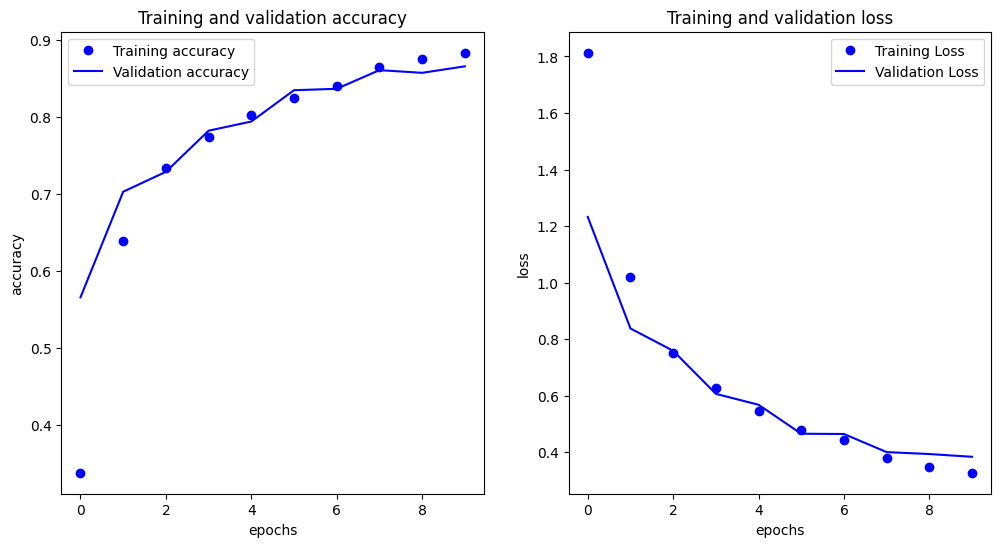

In [8]:
# Plots training and validation accuracy and loss from the model's history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.show()

In [9]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)

print(f"Akurasi model: {accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8472 - loss: 0.4220
Akurasi model: 0.85


In [10]:
# Save model to a h5 file
model.save("capstonee-model.h5")